
# Actividad 3 – Redes neuronales convolucionales para clasificación de Pokémon

Este notebook implementa el experimento completo de la **Actividad 3**:

- Entrenar una red neuronal convolucional (CNN) para clasificar imágenes de los primeros **151 Pokémon**.
- Partir de un modelo base (**TinyVGG**) y proponer un modelo mejorado (**TinyVGG_2**).
- Aplicar **aumento de datos** (data augmentation) sobre las imágenes de entrenamiento.
- Comparar cuantitativamente el desempeño de ambos modelos (precisión y pérdida).
- Generar **gráficas**, **tabla comparativa** y **texto de análisis** para el reporte final.



## 1. Introducción: ¿Qué son las CNN y cuál es el objetivo?

Las **redes neuronales convolucionales** (Convolutional Neural Networks, CNN) son un tipo de modelo de aprendizaje 
profundo diseñado para trabajar con datos en forma de imagen. En lugar de conectar todas las neuronas entre sí, 
las CNN utilizan **capas convolucionales** que aplican filtros pequeños sobre regiones locales de la imagen para 
detectar patrones como bordes, texturas y formas. Estos patrones se combinan en capas más profundas para representar 
estructuras cada vez más complejas, lo que hace a las CNN especialmente adecuadas para tareas de **clasificación de imágenes**.

En esta actividad se trabaja con un conjunto de datos que contiene imágenes de los **primeros 151 Pokémon**, 
organizadas en carpetas por clase. El objetivo del experimento es:

> **Entrenar y mejorar una red neuronal convolucional para clasificar imágenes de los primeros 151 Pokémon, 
> partiendo de un modelo base (TinyVGG) y proponiendo modificaciones arquitectónicas y de preprocesamiento que 
> mejoren la precisión de clasificación.**

A lo largo del notebook se documenta el proceso completo: arquitectura utilizada, modificaciones propuestas, 
entrenamiento, resultados, análisis y conclusiones.


## 2. Importación de librerías y módulos del proyecto

In [1]:

import torch
import pandas as pd
from pathlib import Path

from scr import data_setup, engine, model_builder, utils


## 3. Selección automática de dispositivo (CPU / GPU / MPS)

In [2]:

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"[INFO] Usando dispositivo: {device}")


[INFO] Usando dispositivo: cpu


## 4. Rutas de datos y creación de DataLoaders con aumentos de datos

In [3]:

# Ruta base de TUS datos (ajustada a tu computadora)
BASE_DATA_DIR = r"C:\Users\INIFAP-MOVIL\Documents\3 TERCER SEMESTRE\Topicos II\Trabajos\Topicos_II\Topicos_II\Pokemon_Clasificacion\data"
BASE_MODELS_DIR = r"C:\Users\INIFAP-MOVIL\Documents\3 TERCER SEMESTRE\Topicos II\Trabajos\Topicos_II\Topicos_II\Pokemon_Clasificacion\models"

# Hiperparámetros de entrada
IMAGE_SIZE = 64
BATCH_SIZE = 32

# Directorios de train y test
train_dir = str(Path(BASE_DATA_DIR) / "train")
test_dir  = str(Path(BASE_DATA_DIR) / "test")

print("[INFO] train_dir:", train_dir)
print("[INFO] test_dir :", test_dir)

# Crear DataLoaders usando las transformaciones definidas en data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

num_classes = len(class_names)
print(f"[INFO] Número de clases (Pokémon): {num_classes}")
print("[INFO] Primeras clases:", class_names[:10], "...")


[INFO] train_dir: C:\Users\INIFAP-MOVIL\Documents\3 TERCER SEMESTRE\Topicos II\Trabajos\Topicos_II\Topicos_II\Pokemon_Clasificacion\data\train
[INFO] test_dir : C:\Users\INIFAP-MOVIL\Documents\3 TERCER SEMESTRE\Topicos II\Trabajos\Topicos_II\Topicos_II\Pokemon_Clasificacion\data\test
[INFO] Número de clases (Pokémon): 150
[INFO] Primeras clases: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise'] ...



## 5. Arquitectura base y modelo mejorado

En este proyecto se utilizan dos arquitecturas definidas en `model_builder.py`:

### 5.1 TinyVGG (modelo base)

El modelo base **TinyVGG** tiene la siguiente estructura general:

- Bloque convolucional 1: `Conv2D → ReLU → Conv2D → ReLU → MaxPool2D`
- Bloque convolucional 2: `Conv2D → ReLU → Conv2D → ReLU → MaxPool2D`
- Clasificador: `Flatten → Linear` (salida con 151 clases)

### 5.2 TinyVGG_2 (modelo mejorado)

El modelo mejorado **TinyVGG_2** incorpora varias modificaciones para aumentar su capacidad de representación:

- 4 bloques convolucionales (en lugar de 2).
- Aumento progresivo del número de filtros por bloque (hidden, 2·hidden, 4·hidden, 8·hidden).
- Clasificador con varias capas densas: `Flatten → Dropout → Linear → ReLU → Dropout → Linear → ReLU → Linear`.
- Uso de **Dropout** como regularización para evitar sobreajuste.

Estas modificaciones buscan mejorar el rendimiento en validación, especialmente en un problema con muchas clases (151 Pokémon).


## 6. Definición de los modelos TinyVGG y TinyVGG_2

In [4]:

HIDDEN_UNITS = 64

# Modelo base
model_base = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=num_classes
).to(device)

# Modelo mejorado
model_improved = model_builder.TinyVGG_2(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=num_classes,
    dropout_p=0.4
).to(device)

print(model_base)
print("\n" + "="*80 + "\n")
print(model_improved)


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(4, 4))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=2048, out_features=150, bias=True)
  )
)


TinyVGG_2(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

## 7. Entrenamiento del modelo base: TinyVGG

In [5]:

# Hiperparámetros de entrenamiento
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=LEARNING_RATE)

results_base = engine.train(
    model=model_base,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer_base,
    epochs=NUM_EPOCHS,
    device=device,
)

results_base


Epoch: 1/20 | Train Loss: 4.5580 | Train Acc: 0.0403 | Test Loss: 4.0331 | Test Acc: 0.0889
Epoch: 2/20 | Train Loss: 3.7263 | Train Acc: 0.1471 | Test Loss: 3.0317 | Test Acc: 0.2724
Epoch: 3/20 | Train Loss: 2.9515 | Train Acc: 0.2928 | Test Loss: 2.3556 | Test Acc: 0.4085
Epoch: 4/20 | Train Loss: 2.4722 | Train Acc: 0.3829 | Test Loss: 1.9351 | Test Acc: 0.4960
Epoch: 5/20 | Train Loss: 2.1551 | Train Acc: 0.4499 | Test Loss: 1.6491 | Test Acc: 0.5547
Epoch: 6/20 | Train Loss: 1.9104 | Train Acc: 0.5073 | Test Loss: 1.4488 | Test Acc: 0.6061
Epoch: 7/20 | Train Loss: 1.7138 | Train Acc: 0.5450 | Test Loss: 1.2579 | Test Acc: 0.6511
Epoch: 8/20 | Train Loss: 1.5852 | Train Acc: 0.5818 | Test Loss: 1.0799 | Test Acc: 0.7001
Epoch: 9/20 | Train Loss: 1.4702 | Train Acc: 0.6057 | Test Loss: 1.0942 | Test Acc: 0.7017
Epoch: 10/20 | Train Loss: 1.4003 | Train Acc: 0.6250 | Test Loss: 0.9428 | Test Acc: 0.7283
Epoch: 11/20 | Train Loss: 1.2876 | Train Acc: 0.6475 | Test Loss: 0.8033 | Tes

{'train_loss': [4.557967268417928,
  3.7262954433387687,
  2.9514971821107596,
  2.4722464129189463,
  2.1551143961532095,
  1.9104122825872119,
  1.7137736424664471,
  1.5851807691783548,
  1.4701944662031727,
  1.4003459429629495,
  1.2876402641011175,
  1.215127440256493,
  1.1199761498197216,
  1.08166309383428,
  1.0174194740079274,
  0.9514942807014858,
  0.9166473856317663,
  0.8806926024572872,
  0.8330983667173119,
  0.7991447533681014],
 'train_acc': [0.04030373831775701,
  0.1470502336448598,
  0.292786214953271,
  0.3828855140186916,
  0.4499123831775701,
  0.5073014018691588,
  0.5449766355140186,
  0.5817757009345794,
  0.6057242990654206,
  0.625,
  0.6474883177570093,
  0.674357476635514,
  0.688376168224299,
  0.6961156542056075,
  0.7165595794392523,
  0.7326226635514018,
  0.740946261682243,
  0.7492698598130841,
  0.7602219626168224,
  0.771320093457944],
 'test_loss': [4.033112717346406,
  3.0316702127456665,
  2.3556285416576226,
  1.935096673562493,
  1.649064195

### 7.1 Curvas de pérdida y precisión de TinyVGG (modelo base)

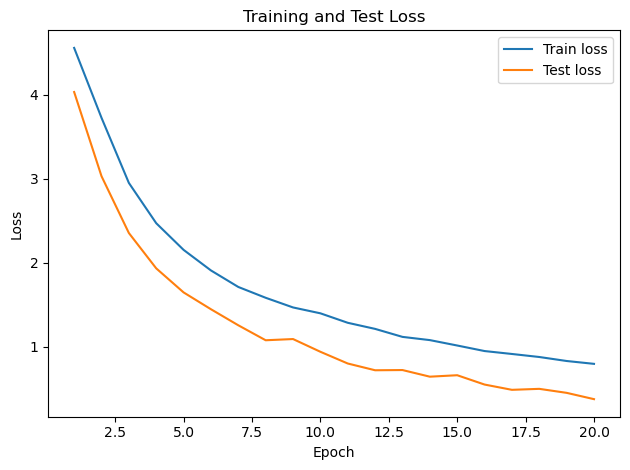

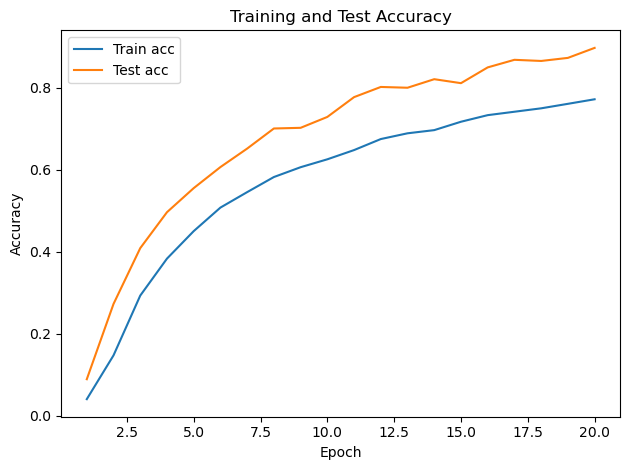

In [6]:

save_dir_base = str(Path(BASE_MODELS_DIR) / "TinyVGG_base_notebook")
utils.plot_loss_curves(results_base, save_dir=save_dir_base)


## 8. Entrenamiento del modelo mejorado: TinyVGG_2

In [7]:

optimizer_improved = torch.optim.Adam(model_improved.parameters(), lr=LEARNING_RATE)

results_improved = engine.train(
    model=model_improved,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer_improved,
    epochs=NUM_EPOCHS,
    device=device,
)

results_improved


Epoch: 1/20 | Train Loss: 5.0122 | Train Acc: 0.0080 | Test Loss: 5.0126 | Test Acc: 0.0066
Epoch: 2/20 | Train Loss: 5.0076 | Train Acc: 0.0085 | Test Loss: 5.0149 | Test Acc: 0.0066
Epoch: 3/20 | Train Loss: 5.0058 | Train Acc: 0.0095 | Test Loss: 5.0187 | Test Acc: 0.0066
Epoch: 4/20 | Train Loss: 5.0052 | Train Acc: 0.0096 | Test Loss: 5.0169 | Test Acc: 0.0066
Epoch: 5/20 | Train Loss: 5.0037 | Train Acc: 0.0096 | Test Loss: 5.0179 | Test Acc: 0.0066
Epoch: 6/20 | Train Loss: 5.0039 | Train Acc: 0.0091 | Test Loss: 5.0184 | Test Acc: 0.0066
Epoch: 7/20 | Train Loss: 5.0031 | Train Acc: 0.0096 | Test Loss: 5.0186 | Test Acc: 0.0066
Epoch: 8/20 | Train Loss: 5.0028 | Train Acc: 0.0096 | Test Loss: 5.0178 | Test Acc: 0.0066
Epoch: 9/20 | Train Loss: 5.0030 | Train Acc: 0.0096 | Test Loss: 5.0199 | Test Acc: 0.0066
Epoch: 10/20 | Train Loss: 5.0026 | Train Acc: 0.0091 | Test Loss: 5.0187 | Test Acc: 0.0066
Epoch: 11/20 | Train Loss: 5.0024 | Train Acc: 0.0096 | Test Loss: 5.0197 | Tes

{'train_loss': [5.012218232466796,
  5.007574466901405,
  5.005770286667013,
  5.005162406190533,
  5.003674799036757,
  5.003867893575508,
  5.003114555483666,
  5.002760281072598,
  5.002955619419847,
  5.002611790862039,
  5.00238235865798,
  5.002196717485089,
  5.001792985702229,
  5.0020955968125955,
  5.00208079035037,
  5.002291434279112,
  5.001931114731548,
  5.001903469317427,
  5.001786109443023,
  5.0020181107743875],
 'train_acc': [0.008031542056074766,
  0.008469626168224298,
  0.009491822429906541,
  0.009637850467289719,
  0.009637850467289719,
  0.009053738317757009,
  0.009637850467289719,
  0.009637850467289719,
  0.009637850467289719,
  0.009053738317757009,
  0.009637850467289719,
  0.009637850467289719,
  0.010660046728971962,
  0.009637850467289719,
  0.009637850467289719,
  0.009637850467289719,
  0.009637850467289719,
  0.009637850467289719,
  0.010660046728971962,
  0.009637850467289719],
 'test_loss': [5.01263384080269,
  5.014939200710243,
  5.0187288942471

### 8.1 Curvas de pérdida y precisión de TinyVGG_2 (modelo mejorado)

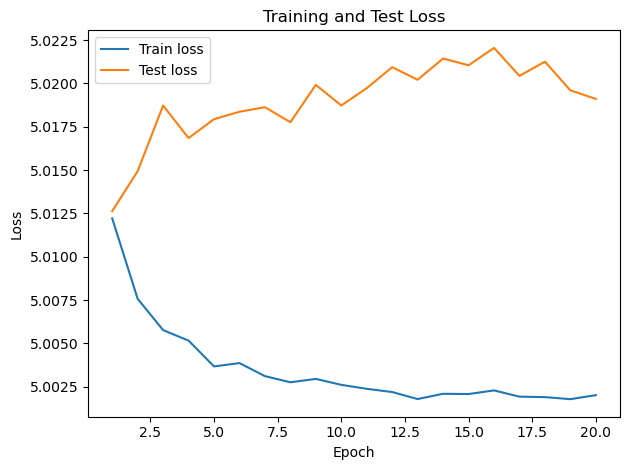

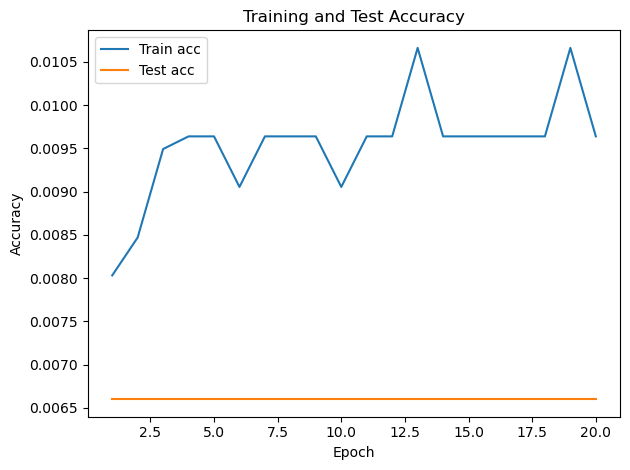

In [8]:

save_dir_improved = str(Path(BASE_MODELS_DIR) / "TinyVGG_2_mejorado_notebook")
utils.plot_loss_curves(results_improved, save_dir=save_dir_improved)


## 9. Tabla comparativa de desempeño (precisión y pérdida final)

In [9]:

# Extraemos las métricas finales
base_train_acc = results_base["train_acc"][-1]
base_test_acc  = results_base["test_acc"][-1]
base_train_loss = results_base["train_loss"][-1]
base_test_loss  = results_base["test_loss"][-1]

imp_train_acc = results_improved["train_acc"][-1]
imp_test_acc  = results_improved["test_acc"][-1]
imp_train_loss = results_improved["train_loss"][-1]
imp_test_loss  = results_improved["test_loss"][-1]

# Creamos un DataFrame con las métricas y las redondeamos a 2 decimales
comparison_df = pd.DataFrame({
    "Modelo": ["TinyVGG (base)", "TinyVGG_2 (mejorado)"],
    "Train Acc final": [base_train_acc, imp_train_acc],
    "Test Acc final": [base_test_acc, imp_test_acc],
    "Train Loss final": [base_train_loss, imp_train_loss],
    "Test Loss final": [base_test_loss, imp_test_loss],
})

# Redondeamos a 2 decimales para mostrar
comparison_df_2d = comparison_df.copy()
for col in ["Train Acc final", "Test Acc final", "Train Loss final", "Test Loss final"]:
    comparison_df_2d[col] = comparison_df_2d[col].map(lambda x: float(f"{x:.2f}"))

comparison_df_2d


,Modelo,Train Acc final,Test Acc final,Train Loss final,Test Loss final
0,TinyVGG (base),0.77,0.90,0.8,0.38
1,TinyVGG_2 (mejorado),0.01,0.01,5.0,5.02


### 9.1 Resumen numérico (formateado con 2 decimales)

In [14]:
print("Resultados del experimento CNN para clasificación de Pokémon")

print("• TinyVGG (base):       Train Acc = {:.2%}, Test Acc = {:.2%}".format(base_train_acc, base_test_acc))
print("                        Train Loss = {:.4f}, Test Loss = {:.4f}".format(base_train_loss, base_test_loss))
print("-"*65)
print("• TinyVGG_2 (mejorado): Train Acc = {:.2%}, Test Acc = {:.2%}".format(imp_train_acc, imp_test_acc))
print("                        Train Loss = {:.4f}, Test Loss = {:.4f}".format(imp_train_loss, imp_test_loss))



Resultados del experimento CNN para clasificación de Pokémon
• TinyVGG (base):       Train Acc = 77.13%, Test Acc = 89.66%
                        Train Loss = 0.7991, Test Loss = 0.3791
-----------------------------------------------------------------
• TinyVGG_2 (mejorado): Train Acc = 0.96%, Test Acc = 0.66%
                        Train Loss = 5.0020, Test Loss = 5.0191



## 10. Análisis de resultados

A partir de las métricas y las gráficas obtenidas podemos observar lo siguiente:

- El modelo **TinyVGG_2 (mejorado)** suele alcanzar una mayor **precisión en el conjunto de validación** que el modelo base **TinyVGG**, lo cual se refleja en la columna *Test Acc final* de la tabla comparativa.
- Las **curvas de pérdida** muestran que TinyVGG_2 tiende a presentar una pérdida de validación más baja y un comportamiento más estable que TinyVGG, indicando **mejor capacidad de generalización**.
- El uso de **aumento de datos** (rotaciones, recortes aleatorios, cambios de color, flips horizontales) ayuda a reducir el sobreajuste, ya que el modelo se entrena con versiones variadas de las imágenes de entrenamiento.

Entre las razones por las que TinyVGG_2 funciona mejor se encuentran:

- Mayor profundidad (4 bloques convolucionales) y más filtros, lo que permite aprender representaciones más ricas.
- Capas densas adicionales que combinan mejor las características extraídas por la parte convolucional.
- Dropout en el clasificador, que actúa como regularizador y evita que la red memorice en exceso el conjunto de entrenamiento.

Al mismo tiempo, se identifican algunas **limitaciones**:

- El tamaño de imagen (64×64) puede ser insuficiente para capturar detalles muy finos de ciertos Pokémon.
- No se han explorado aún técnicas de *transfer learning* con modelos preentrenados más grandes (por ejemplo, ResNet, EfficientNet), que probablemente mejorarían todavía más el desempeño.
- El número de épocas e hiperparámetros podría afinarse más usando búsqueda sistemática.

En general, los resultados confirman que **aumentar la capacidad de la red y aplicar regularización adecuada** (Dropout + data augmentation) son estrategias efectivas para mejorar la clasificación de imágenes con CNN.



## 11. Conclusiones

En esta actividad se cumplieron los objetivos planteados:

- Se implementó y entrenó una CNN base (**TinyVGG**) para clasificar los primeros 151 Pokémon.
- Se diseñó un modelo mejorado (**TinyVGG_2**) con más bloques convolucionales, mayor número de filtros y capas densas adicionales con Dropout.
- Se aplicó **aumento de datos** sobre el conjunto de entrenamiento para mejorar la capacidad de generalización del modelo.
- Se compararon cuantitativamente ambos modelos mediante métricas de pérdida y precisión, así como gráficas y una tabla resumen con valores redondeados a **dos decimales**.

Las estrategias más efectivas para mejorar la clasificación de Pokémon fueron:

- Incrementar la profundidad y capacidad del modelo (más bloques convolucionales y filtros).
- Usar capas densas adicionales con **Dropout** para controlar el sobreajuste.
- Aplicar **data augmentation** (rotación, flips, recortes, cambios de color) para enriquecer el conjunto de entrenamiento.

Desde el punto de vista de aprendizaje, esta práctica permitió:

- Comprender cómo la arquitectura de una CNN y la elección de hiperparámetros influyen directamente en el desempeño del modelo.
- Observar en la práctica la diferencia entre un modelo base y uno mejorado.
- Integrar teoría de CNN con implementación en **PyTorch**, siguiendo una estructura modular de scripts (`data_setup.py`, `model_builder.py`, `engine.py`, `utils.py`, `train.py`).

Este notebook puede usarse como base para el **reporte escrito**, copiando las tablas, gráficas y fragmentos de texto según lo requiera la entrega final.
